# Global indicator project - Phoenix, Arizona

## Create population analysis - with the GHSL Landsat population datasets

This notebook describes the process to import and clip population raster by 250m grid cell (download from [GHSL web](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop)) based on study region boundary. Then the raster data is transformed into shapely polygon and geodataframe in order to conduct GIS functionalities with sample point stats.

The idea is to take average of sample point stats to 250m grid, and visualize the indicator result (eg. walkability) in grid cell. 

**Process:**
1. Load study region boundary
2. Load GHSL population raster data and clip based on study region boundary
3. Define population projection based on studyregion file
4. Convert population raster to polygon features and geodataframe
5. Associate population raster/polygon with sample points stats (next step)

Other notes from Carl: 

- we could use 250m grid cells (restricted to urban regions corresponding to our cities) as our 'universal unit' across all cities: ie. take averages of samples within these areas
- we need to discuss: is population density fine to substitute for dwelling density in walkability formula? We take a z-score in any case, so it becomes an abstract relative measure of much the same thing i think?
- we could visualise final results using population weighted 1km grids (the [Walk and the City example](http://geochoros.survey.ntua.gr/walkandthecity/walkability) shows Walkability spatial distribution across a large number of countries provides a great example of this approach): this mode of visualisation could be adopted for other indicators (eg. estimated percent of population with access to public open space).

Data info: GHS-POP, epoch: 2015, resolution: 250 m, coordinate system: Mollweide  
Data source: https://ghsl.jrc.ec.europa.eu/download.php?ds=pop  
Data packadge report: https://ghsl.jrc.ec.europa.eu/documents/GHSL_Data_Package_2019.pdf?t=1478q532234372  
Map example: http://geochoros.survey.ntua.gr/walkandthecity/walkability  
Method note: https://github.com/gboeing/global-indicators/pull/4 


In [1]:
from setup_GHSpop_urban import *
from config import *

## 1. Load study region boundary

In [2]:
# load study region boundary file and project to lat-long
clipping_boundary = gpd.GeoDataFrame.from_file(boundary_filepath)

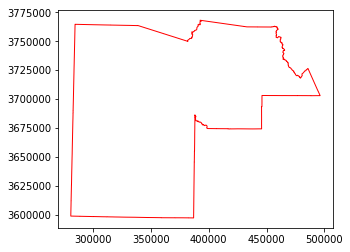

In [17]:
clipping_boundary.plot(edgecolor='red', facecolor='none')

## 2. Load GHSL population raster data and clip based on study region boundary
If the study region population raster files are seperated in different parts by GHS, we could read all the data file and merge into one raster mosaic. Referece post: [Creating a raster mosaic](https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-mosaic.html)

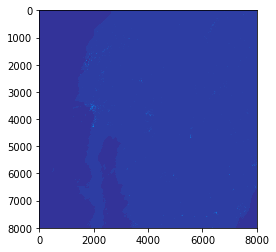

In [3]:
datasets = [population_raster_file1, population_raster_file2, population_raster_file3, population_raster_file4]
population_raster =  '../data/Population/{}_{}.tif'.format('GHS_population', placename)

save_studyregion_GHS_raster(datasets, population_raster)

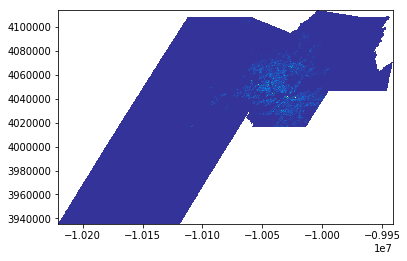

In [5]:
population_raster_clipped =  '../data/Population/{}_clipped_{}.tif'.format('population', placename)
raster_pop = clip_studyregion_GHS_raster(clipping_boundary, population_raster, population_raster_clipped)

show(raster_pop, cmap='terrain')

## 3. Define population projection based on studyregion file

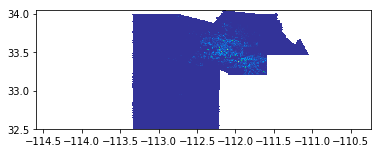

In [7]:
# reproject based on the original study region crs, and save the re-projected clipped raster
# need to discuss projection for study regions
population_raster_clipped =  '../data/Population/{}_clipped_{}.tif'.format('population', placename)
population_raster_projected = '../data/Population/{}_clipped_{}.tif'.format('population_proj', placename)

raster_pop_proj = reproject_raster(inpath = population_raster_clipped, 
              outpath = population_raster_projected, 
              new_crs = to_crs) 
show(raster_pop_proj, cmap='terrain')

## 4. Convert population raster to polygon features and geodataframe
https://gis.stackexchange.com/questions/187877/how-to-polygonize-raster-to-shapely-polygons

convert 250m grid raster to polygon, and geodataframe. shapely geometry and geodataframe. 

In [8]:
polygonized_raster_gdf = raster_to_gdf(population_raster_projected, to_crs)
polygonized_raster_gdf.head()

,geometry,raster_val
2,POLYGON ((-112.7999591910156 34.00040467131404...,0.704449
3,POLYGON ((-112.7964752118525 34.00040467131404...,0.927961
5,POLYGON ((-112.7895072535262 34.00040467131404...,3.058993
6,"POLYGON ((-112.786023274363 34.00040467131404,...",1.354476
7,POLYGON ((-112.7825392951998 34.00040467131404...,1.176245


In [77]:
#save the population dataframe shapefile
ox.save_gdf_shapefile(polygonized_raster_gdf, filename='GHS_proj_2015Pop_250m_{}'.format(placename), folder=pop_folder)

### plot population raster based on study region boundary

In [27]:
# load study region boundary file and project to lat-long
clipping_boundary = gpd.GeoDataFrame.from_file(boundary_filepath)

clipping_boundary = clipping_boundary.to_crs(to_crs)

In [28]:
def map_variable(df, df1, col):
    values = df.dropna(subset=[col])
    ax = values.plot(column=col, scheme='quantiles', k=6, cmap='YlOrBr', figsize=(10,10))
    ax = df1.plot(ax=ax, facecolor="none", edgecolor='blue', linewidth=1)
    plt.show()

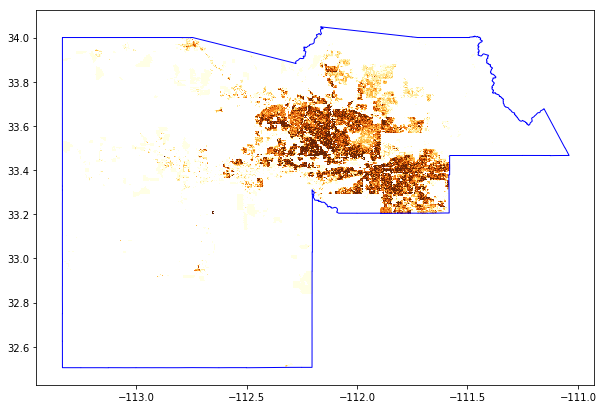

In [29]:
map_variable(polygonized_raster_gdf, clipping_boundary, 'raster_val')

### examine GHS population grid with built-up area 

In [26]:
# load population grid
pop2015 = gpd.GeoDataFrame.from_file(GHS_pop_filepath)

# load edge shapefile
edges_gdf = gpd.GeoDataFrame.from_file(shapefile_path)

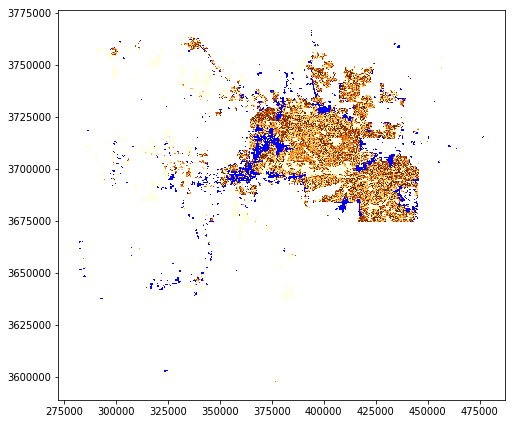

In [29]:
#sample point with the population grid polygon
fig, ax = plt.subplots(figsize=(8, 8))
ax = builtup2014.plot(ax=ax, color='blue', facecolor=None, figsize=(10,10))
ax = pop2015.plot(ax=ax, column='raster_val', scheme='quantiles', k=6, cmap='YlOrBr', figsize=(10,10))

#ax.set_xlim(390000, 392000)
#ax.set_ylim(3692000, 3694000)

plt.show()

## 4. Associate population raster/polygon with sample points stats


In [3]:
#load population raster
gpd_polygonized_raster = gpd.GeoDataFrame.from_file(GHS_pop_filepath)

#load sample point gdf with stats
sample_points = gpd.GeoDataFrame.from_file(samplepoint_filepath)

# load edge shapefile
edges_gdf = gpd.GeoDataFrame.from_file(shapefile_path)

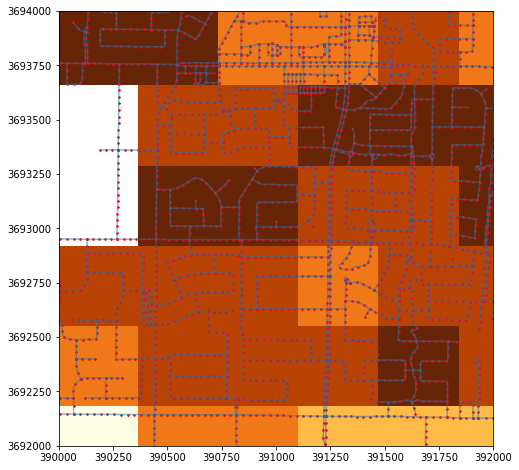

In [20]:
#sample point with the population grid polygon
fig, ax = plt.subplots(figsize=(8, 8))
ax = gpd_polygonized_raster.plot(ax=ax, column='raster_val', scheme='quantiles', k=6, cmap='YlOrBr', figsize=(10,10))
ax = sample_points.plot(ax=ax, color='red', markersize=1.5)
ax = edges_gdf.plot(ax=ax, alpha=0.3)
ax.set_xlim(390000, 392000)
ax.set_ylim(3692000, 3694000)

plt.show()

 **Next steps:**

- evaluate local street connectivity for sample points  
- evaluate a land use mix or proxy score (e.g. 'daily living' access to amenities) for sample points  
- take average of these to 250m grid. (are we averaging all sample points within each grid cell? Or we take sample of the sample points within the the cell and take the average?)
- Then we have population density (pop/area in hectares of 250m grid cell), street connectivity (average connectivity per square km of local road networks in grid cell), and daily living access (average score from 0 to 3 for access to daily living amenities in grid cell) 
- Calculate respective z-scores of pop (or dwelling) density, street connectivity and daily living  
- Sum z-scores for a walkability index calculated for 250m grid cells